In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX,RZ,X,I,Measure
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   # 导入Adam模块和TrainOneStepCell模块

import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import mindquantum as mq
import seaborn as sns
import heapq
import copy
from math import pi


import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import time

from math import pi
from mpl_toolkits.mplot3d import Axes3D


import warnings
warnings.filterwarnings("ignore")

# 将数据保存在服务器上所需代码
import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename,encoding='utf-8'),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/n = 8/ER/graph18.log", "ml_logger")

In [2]:
# Compute the circuit depth using the interface

# right 2021 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""DAG Circuit."""
import typing

from mindquantum.core import Circuit, gates
from mindquantum.utils.type_value_check import _check_input_type

# pylint: disable=invalid-name


class DAGNode:
    """
    Basic node in Directed Acyclic Graph.

    A DAG node has local index, which label the index of leg of node, and child nodes and father nodes.
    """

    def __init__(self):
        """Initialize a DAGNode object."""
        self.child: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: child DAGNode
        self.father: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: father DAGNode
        self.local: typing.List[int] = []

    def clean(self):
        """Clean node and set it to empty."""
        self.child = {}
        self.father = {}
        self.local = []

    def insert_after(self, other_node: "DAGNode"):
        """
        Insert other node after this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.father[local] = self
                if local in self.child:
                    other_node.child[local] = self.child.get(local)
                    self.child.get(local).fathre[local] = other_node
                self.child[local] = other_node

    def insert_before(self, other_node: "DAGNode"):
        """
        Insert other node before this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.child[local] = self
                if local in self.father:
                    other_node.father[local] = self.father.get(local)
                    self.father.get(local).child[local] = other_node
                self.father[local] = other_node


def connect_two_node(father_node: DAGNode, child_node: DAGNode, local_index: int):
    """
    Connect two DAG node through given local_index.

    Args:
        father_node (DAGNode): The father DAG node.
        child_node (DAGNode): The child DAG node.
        local_index (int): which leg you want to connect.
    """
    if local_index not in father_node.local or local_index not in child_node.local:
        raise ValueError(
            f"local_index {local_index} not in father_node" f" {father_node} or not in child_node {child_node}."
        )
    father_node.child[local_index] = child_node
    child_node.father[local_index] = father_node


class DAGQubitNode(DAGNode):
    """
    DAG node that work as quantum qubit.

    Args:
        qubit (int): id of qubit.
    """

    def __init__(self, qubit: int):
        """Initialize a DAGQubitNode object."""
        super().__init__()
        _check_input_type("qubit", int, qubit)
        self.qubit = qubit
        self.local = [qubit]

    def __str__(self):
        """Return a string representation of qubit node."""
        return f"q{self.qubit}"

    def __repr__(self):
        """Return a string representation of qubit node."""
        return self.__str__()


class GateNode(DAGNode):
    """
    DAG node that work as quantum gate.

    Args:
        gate (:class:`~.core.gates.BasicGate`): Quantum gate.
    """

    def __init__(self, gate: gates.BasicGate):
        """Initialize a GateNode object."""
        super().__init__()
        _check_input_type("gate", gates.BasicGate, gate)
        self.gate = gate
        self.local = gate.obj_qubits + gate.ctrl_qubits

    def __str__(self):
        """Return a string representation of gate node."""
        return str(self.gate)

    def __repr__(self):
        """Return a string representation of gate node."""
        return self.__str__()


class BarrierNode(GateNode):
    """DAG node that work as barrier."""

    def __init__(self, gate: gates.BasicGate, all_qubits: typing.List[int]):
        """Initialize a BarrierNode object."""
        super().__init__(gate)
        self.local = all_qubits


class DAGCircuit:
    """
    A Directed Acyclic Graph of a quantum circuit.

    Args:
        circuit (:class:`~.core.circuit.Circuit`): the input quantum circuit.

    Examples:
    from mindquantum.algorithm.compiler import DAGCircuit
    from mindquantum.core.circuit import Circuit
    circ = Circuit().h(0).x(1, 0)
    dag_circ = DAGCircuit(circ)
    dag_circ.head_node[0]
        q0
    dag_circ.head_node[0].child
        {0: H(0)}
    """

    def __init__(self, circuit: Circuit):
        """Initialize a DAGCircuit object."""
        _check_input_type("circuit", Circuit, circuit)
        self.head_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        self.final_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        for i in self.head_node:
            self.head_node[i].insert_after(self.final_node[i])
        for gate in circuit:
            if isinstance(gate, gates.BarrierGate):
                if gate.obj_qubits:
                    self.append_node(BarrierNode(gate, sorted(gate.obj_qubits)))
                else:
                    self.append_node(BarrierNode(gate, sorted(circuit.all_qubits.keys())))
            else:
                self.append_node(GateNode(gate))
        self.global_phase = gates.GlobalPhase(0)

    @staticmethod
    def replace_node_with_dag_circuit(node: DAGNode, coming: "DAGCircuit"):
        """
        Replace a node with a DAGCircuit.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the original DAG node.
            coming (:class:`~.algorithm.compiler.DAGCircuit`): the coming DAG circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().x(1, 0)
        circ
            q0: ────■─────
                    ┃
                  ┏━┻━┓
            q1: ──┨╺╋╸┠───
                  ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = dag_circ.head_node[0].child[0]
        node
            X(1 <-: 0)
        sub_dag = DAGCircuit(Circuit().h(1).z(1, 0).h(1))
        DAGCircuit.replace_node_with_dag_circuit(node, sub_dag)
        dag_circ.to_circuit()
            q0: ──────────■───────────
                          ┃
                  ┏━━━┓ ┏━┻━┓ ┏━━━┓
            q1: ──┨ H ┠─┨ Z ┠─┨ H ┠───
                  ┗━━━┛ ┗━━━┛ ┗━━━┛
        """
        if set(node.local) != {head.qubit for head in coming.head_node.values()}:
            raise ValueError(f"Circuit in coming DAG is not aligned with gate in node: {node}")
        for local in node.local:
            connect_two_node(node.father[local], coming.head_node[local].child[local], local)
            connect_two_node(coming.final_node[local].father[local], node.child[local], local)

    def append_node(self, node: DAGNode):
        """
        Append a quantum gate node.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the DAG node you want to append.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit, GateNode
        from mindquantum.core.circuit import Circuit
        import mindquantum.core.gates as G
        circ = Circuit().h(0).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                        ┏━┻━┓
            q1: ────────┨╺╋╸┠───
                        ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = GateNode(G.RX('a').on(0, 2))
        dag_circ.append_node(node)
        dag_circ.to_circuit()
                  ┏━━━┓       ┏━━━━━━━┓
            q0: ──┨ H ┠───■───┨ RX(a) ┠───
                  ┗━━━┛   ┃   ┗━━━┳━━━┛
                        ┏━┻━┓     ┃
            q1: ────────┨╺╋╸┠─────╂───────
                        ┗━━━┛     ┃
                                  ┃
            q2: ──────────────────■───────
        """
        _check_input_type('node', DAGNode, node)
        for local in node.local:
            if local not in self.head_node:
                self.head_node[local] = DAGQubitNode(local)
                self.final_node[local] = DAGQubitNode(local)
                self.head_node[local].insert_after(self.final_node[local])
            self.final_node[local].insert_before(node)

    def depth(self) -> int:
        """
        Return the depth of quantum circuit.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        DAGCircuit(circ).depth()
            2
        """
        return len(self.layering())

    def find_all_gate_node(self) -> typing.List[GateNode]:
        """
        Find all gate node in this :class:`~.algorithm.compiler.DAGCircuit`.

        Returns:
            List[:class:`~.algorithm.compiler.GateNode`], a list of all :class:`~.algorithm.compiler.GateNode`
            of this :class:`~.algorithm.compiler.DAGCircuit`.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().h(0).x(1, 0)
        dag_circ = DAGCircuit(circ)
        dag_circ.find_all_gate_node()
            [H(0), X(1 <-: 0)]
        """
        found = set(self.head_node.values())

        def _find(current_node: DAGNode, found):
            if current_node not in found:
                found.add(current_node)
                for node in current_node.father.values():
                    _find(node, found)
                for node in current_node.child.values():
                    _find(node, found)

        for head_node in self.head_node.values():
            for current_node in head_node.child.values():
                _find(current_node, found)
        return [i for i in found if not isinstance(i, DAGQubitNode)]

    def layering(self) -> typing.List[Circuit]:
        r"""
        Layering the quantum circuit.

        Returns:
            List[:class:`~.core.circuit.Circuit`], a list of layered quantum circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.utils import random_circuit
        circ = random_circuit(3, 5, seed=42)
        circ
                  ┏━━━━━━━━━━━━━┓   ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠─╳─┨ RY(-6.1944) ┠───────────────────
                  ┃             ┃ ┃ ┗━━━━━━┳━━━━━━┛
                  ┃ Rxx(1.2171) ┃ ┃        ┃        ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠─┃────────╂────────┨             ┠───
                  ┗━━━━━━━━━━━━━┛ ┃        ┃        ┃             ┃
                  ┏━━━━━━━━━━━━┓  ┃        ┃        ┃ Rzz(-0.552) ┃
            q2: ──┨ PS(2.6147) ┠──╳────────■────────┨             ┠───
                  ┗━━━━━━━━━━━━┛                    ┗━━━━━━━━━━━━━┛
        dag_circ = DAGCircuit(circ)
        for idx, c in enumerate(dag_circ.layering()):
            ...     print(f"layer {idx}:")
            ...     print(c)
            layer 0:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠───
                  ┃             ┃
                  ┃ Rxx(1.2171) ┃
            q1: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
                  ┏━━━━━━━━━━━━┓
            q2: ──┨ PS(2.6147) ┠────
                  ┗━━━━━━━━━━━━┛
            layer 1:
            q0: ──╳───
                  ┃
                  ┃
            q2: ──╳───
            layer 2:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨ RY(-6.1944) ┠───
                  ┗━━━━━━┳━━━━━━┛
                         ┃
            q2: ─────────■──────────
            layer 3:
                  ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠───
                  ┃             ┃
                  ┃ Rzz(-0.552) ┃
            q2: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
        """

        def _layering(current_node: GateNode, depth_map):
            """Layering the quantum circuit."""
            if current_node.father:
                prev_depth = []
                for father_node in current_node.father.values():
                    if father_node not in depth_map:
                        _layering(father_node, depth_map)
                    prev_depth.append(depth_map[father_node])
                depth_map[current_node] = max(prev_depth) + 1
            for child in current_node.child.values():
                if not isinstance(child, DAGQubitNode):
                    if child not in depth_map:
                        _layering(child, depth_map)

        depth_map = {i: 0 for i in self.head_node.values()}
        for current_node in self.head_node.values():
            _layering(current_node, depth_map)
        layer = [Circuit() for _ in range(len(set(depth_map.values())) - 1)]
        for k, v in depth_map.items():
            if v != 0:
                if not isinstance(k, BarrierNode):
                    layer[v - 1] += k.gate
        return [c for c in layer if len(c) != 0]

    def to_circuit(self) -> Circuit:
        """
        Convert :class:`~.algorithm.compiler.DAGCircuit` to quantum circuit.

        Returns:
            :class:`~.core.circuit.Circuit`, the quantum circuit of this DAG.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        dag_circ = DAGCircuit(circ)
        dag_circ.to_circuit()
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        """
        circuit = Circuit()
        considered_node = set(self.head_node.values())

        def adding_current_node(current_node, circuit, considered):
            if all(i in considered for i in current_node.father.values()) and not isinstance(
                current_node, DAGQubitNode
            ):
                circuit += current_node.gate
                considered.add(current_node)
            else:
                for node in current_node.father.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)
                for node in current_node.child.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)

        for current_node in self.final_node.values():
            adding_current_node(current_node, circuit, considered_node)
        return circuit

In [3]:
# Function to retrieve information about the neighbors of each vertex in graph g
def get_info_neighbors(g):
    info = {}  # Dictionary to store neighbor information for each vertex
    
    n = len(g.nodes())  # Get the number of vertices in the graph g
    
    # Iterate through all vertices in the graph
    for k in g.nodes():
        neighbors = []  #List to store neighbors of the current vertex k
        
        # Iterate through all edges in the graph
        for u, v in g.edges:
            # Check if vertex v is adjacent to k
            if v == k:
                neighbors.append(u)  # Add the other endpoint u as a neighbor
            
            # Check if vertex u is adjacent to k
            if u == k:
                neighbors.append(v)  # Add the other endpoint v as a neighbor
        
        # Store the vertex k and its neighbors in the dictionary
        info[k] = neighbors
    
    # Optional: Log the information about vertices and their neighbors (commented out)
    # my_logger.info('Vertex and its neighbors: {}'.format(info))
    
    return info  # Return the dictionary containing neighbor information

In [4]:
# Function to create the initial quantum state, here chosen as the all-zero state
def create_encoder():
    encoder = Circuit()  # Initialize an empty quantum circuit
    return encoder  # Return the quantum circuit

# Function to construct one layer of the target unitary operator based on the target Hamiltonian, parameterized by gamma
def build_U_HD(layer, target_graph):
    # Initialize a quantum circuit
    cir_HD = Circuit()
    
    # Add RZ gates for each vertex in the target graph, parameterized by gamma
    for v in target_graph.nodes:
        cir_HD += RZ('gamma{}'.format(layer)).on(v)
    
    return cir_HD  # Return the constructed circuit

# Function to construct one layer of the mixer unitary operator based on the initial Hamiltonian, parameterized by beta
def build_U_HM(layer, info):
    # Initialize a quantum circuit for n qubits
    cir_HM = Circuit()
    
    # Iterate through the neighbor information dictionary
    for key, value in info.items():
        if len(value) != 0:
            # MindQuantum only supports controlled gates where control qubits are all |1>,
            # To achieve flipping with all control qubits in |0>, we process the control qubits
            
            # Flip the states of neighboring qubits
            for i in range(len(value)):
                cir_HM += X.on(value[i])  # Apply X gate to flip the qubit
            
            # Apply a multi-qubit controlled RX gate with the target as the first qubit
            cir_HM += RX('beta{}'.format(layer)).on(key, value)
            
            # Flip the states of neighboring qubits back to the original
            for i in range(len(value)):
                cir_HM += X.on(value[i])
            
            # Add a barrier for clarity and separation
            cir_HM.barrier()
        else:
            # If the vertex is isolated, directly add it to the vertex subset
            cir_HM += RX('beta{}'.format(layer)).on(key)  # Apply RX gate to the isolated qubit
            cir_HM.barrier()  # Add a barrier for clarity

    return cir_HM  # Return the constructed mixer unitary operator circuit

# Function to construct a p-layer QAOA+ ansatz
def build_ansatz(p, target_graph):
    # Prepare the initial state; any feasible solution can be used
    encoder = create_encoder()
    
    # Get neighbor information for the target graph to assist in circuit construction
    info = get_info_neighbors(target_graph)
    
    # Construct the QAOA+ ansatz with p layers; alternate between the target and initial Hamiltonian circuits
    ansatz = Circuit()
    for layer in range(1, p + 1):
        ansatz += build_U_HD(layer, target_graph)  # Add the target Hamiltonian circuit
        ansatz += build_U_HM(layer, info)         # Add the mixer Hamiltonian circuit
        
        # Add a barrier to separate layers
        ansatz.barrier()
    
    return encoder, ansatz  # Return the initial state circuit and the ansatz circuit


In [5]:
# Function to construct the initial parameterized quantum circuit (PQC)
# Methods 2 and 3 apply mixers only on a subset of vertices
def build_initial_PQC(target_graph):
    # Method 1: Apply mixers on all vertices (i.e., using a complete QAOA+ ansatz for one layer)
    # Uncomment the following lines to enable Method 1
    # encoder, ansatz = build_ansatz(1, target_graph)
    # circ = encoder + ansatz
    # allowed_applied_nodes = []
    # for node in V:
    #     allowed_applied_nodes.append(node)

    # Method 2: Assign mixers based on node degree
    # If the degree of a node is less than or equal to the average degree, assign a mixer
    # Uncomment the following lines to enable Method 2
    # m = len(E)  # Number of edges in the graph
    # avg_d = (2 * m) / len(V)  # Calculate the average degree
    # layer = 1  # Specify the layer
    # allowed_applied_nodes = []  # List of vertices allowed for mixer application
    # for node, values in info.items():
    #     d = len(info[node])  # Degree of the node
    #     if d <= avg_d:
    #         allowed_applied_nodes.append(node)
    #
    # # Construct the target Hamiltonian unitary operation
    # circ = build_U_HD(1, target_graph)
    #
    # # Construct the mixer Hamiltonian unitary operation
    # for node in allowed_applied_nodes:
    #     value = info[node]  # Get neighbors of the node
    #     
    #     # Apply mixers on the node
    #     if len(value) != 0:
    #         # Flip the states of neighboring qubits
    #         for i in range(len(value)):
    #             circ += X.on(value[i])
    #
    #         # Apply a multi-qubit controlled RX gate
    #         circ += RX('beta{}'.format(layer)).on(node, value)
    #
    #         # Flip the states of neighboring qubits back to original
    #         for i in range(len(value)):
    #             circ += X.on(value[i])
    #
    #         circ.barrier()  # Add a barrier
    #     else:
    #         # Apply RX gate directly for isolated vertices
    #         circ += RX('beta{}'.format(layer)).on(node)
    #         circ.barrier()

    # Method 3: Random assignment of vertices (suitable for regular graphs)
    layer = 1  # Specify the layer
    allowed_applied_nodes = []  # List to store vertices for mixer application
    # For regular graphs, randomly select t vertices where t <= min{t1, t2}
    t1 = n - k  # Compute t1 based on the problem requirements
    t2 = int(n / 2)  # Compute t2 as half the number of vertices
    t = min(t1, t2)  # Take the smaller of t1 and t2

    # Randomly select t vertices for mixer application
    while len(allowed_applied_nodes) <= t:
        node = random.randint(0, n - 1)  # Select a random vertex
        if node not in allowed_applied_nodes:
            allowed_applied_nodes.append(node)
    my_logger.info('Vertices selected for mixer application in the first layer: {}'.format(allowed_applied_nodes))

    # Construct the target Hamiltonian unitary operation
    circ = build_U_HD(1, target_graph)

    # Construct the mixer Hamiltonian unitary operation
    for node in allowed_applied_nodes:
        value = info[node]  # Get neighbors of the node

        # Apply mixers on the node
        if len(value) != 0:
            # Flip the states of neighboring qubits
            for i in range(len(value)):
                circ += X.on(value[i])

            # Apply a multi-qubit controlled RX gate
            circ += RX('beta{}'.format(layer)).on(node, value)

            # Flip the states of neighboring qubits back to original
            for i in range(len(value)):
                circ += X.on(value[i])

            circ.barrier()  # Add a barrier
        else:
            # Apply RX gate directly for isolated vertices
            circ += RX('beta{}'.format(layer)).on(node)
            circ.barrier()

    return circ, allowed_applied_nodes  # Return the constructed circuit and the selected nodes


In [6]:
# Build the updated quantum circuit
# The updated circuit is constructed by adding the latest operators to the already optimized circuit.
# The list `applied_nodes` contains the vertices where mixers are allowed, and `info` provides adjacency information.
def build_latest_PQC(updated_pqc, layer, applied_nodes, info):
    """
    Build the latest parameterized quantum circuit (PQC).
    
    Args:
        updated_pqc: The current quantum circuit that has been optimized so far.
        layer: The current layer of the circuit.
        applied_nodes: List of vertices where mixers are allowed to act.
        info: Dictionary containing adjacency information for each vertex.
    
    Returns:
        updated_pqc: The updated quantum circuit with the new operators applied.
    """
    # Add a new layer of the target unitary operator
    updated_pqc += build_U_HD(layer, target_graph)
    
    # Add adaptive \( e^{-i \beta H_{M}} \) operations for the specified layer
    for node in applied_nodes:
        value = info[node]  # Retrieve neighboring nodes for the current vertex

        # Apply the corresponding mixer on the vertex
        if len(value) != 0:  # If the vertex has neighbors
            # Apply X gates to flip the state of neighboring qubits
            for i in range(len(value)):
                updated_pqc += X.on(value[i])

            # Apply a multi-qubit controlled RX gate
            # The first argument is the target qubit (the node itself), and the second is the list of control qubits (neighbors)
            updated_pqc += RX('beta{}'.format(layer)).on(node, value)

            # Apply X gates again to revert the state of neighboring qubits
            for i in range(len(value)):
                updated_pqc += X.on(value[i])

            updated_pqc.barrier()  # Add a barrier for clarity in visualization
        else:
            # Directly apply the RX gate if the vertex is isolated (no neighbors)
            updated_pqc += RX('beta{}'.format(layer)).on(node)
            updated_pqc.barrier()  # Add a barrier for clarity
    
    return updated_pqc


In [7]:
# Function to calculate the initial expectation function value given the initial parameters
# N_pm represents the number of mixers in the current layer
# Lists beta and gamma store the current circuit parameters (including the new layer and the optimized layer)
def calculate_initial_expectation_value(circ, beta, gamma):
    # Store parameters: first store gamma parameters, then beta parameters
    params = []
    for i in range(len(gamma)):
        params.append(gamma[i])  # Add gamma parameters to the parameter list
    
    # For the mixer unitary operation, reuse optimized parameters for the first (p-1) layers
    # Randomly initialize parameters for the p-th layer
    for i in range(len(beta)):
        params.append(beta[i])  # Add beta parameters to the parameter list
    
    
    # Create a simulator using 'mqvector' backend
    # The simulator can handle circuits with up to the number of qubits specified in 'circ'
    sim = Simulator('projectq', circ.n_qubits)
    
    # Create a parameter resolver to map circuit parameters to their values
    pr = dict(zip(circ.params_name, params))
    
    # Apply the circuit to the simulator with the resolved parameters
    sim.apply_circuit(circ, pr=pr)
    
    # Uncomment the following line to print the quantum state (debugging purposes)
    # print(sim.get_qs(True))
    
    # Compute the expectation value of the Hamiltonian
    expectation = sim.get_expectation(ham)
    
    # Return the negative real part of the expectation value
    # (Assuming minimization is the goal in the optimization process)
    return -1 * (expectation.real)


In [8]:
class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad, params, weight='normal'):
        """
        Initialize an MQAnsatzOnlyLayer object.
        
        Args:
            expectation_with_grad: An object that computes the expectation value and its gradient.
            params: Initial parameters for the quantum ansatz (a numpy array of shape [gamma0, beta0, gamma1, beta1, ...]).
            weight: Initialization method for the parameter weights. Defaults to 'normal'. Can also accept a Tensor.
        """
        super().__init__()  # Initialize the parent class
        
        # Initialize the MQAnsatzOnlyOps object
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        
        # Determine the size of the weight tensor from the ansatz parameters
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
        
        # Validate the shape of the provided weight tensor, if specified
        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(
                    f"Weight init shape error, required ({weight_size}, ), but got {weight.shape}."
                )
        
        # Initialize the parameter tensor
        # Convert the input parameters to a float32 tensor
        # Initial parameters (params) are in the form [gamma0, beta0, gamma1, beta1, ...]
        self.weight = Parameter(params.astype(np.float32), name='ansatz_weight')
        
        # Log the initialized weight values for debugging
        my_logger.info('weight = {}'.format(self.weight.asnumpy()))

    def construct(self):
        """
        Construct the MQAnsatzOnlyLayer node.
        
        This method defines the forward computation of the layer.
        It applies the quantum evolution operator with the current weight parameters.
        """
        return self.evolution(self.weight)

In [9]:
# Function to execute the optimization process for a quantum circuit based on convergence error
def execute_function(target_graph, circuit, beta, gamma):
    """
    Args:
        target_graph: The graph representing the problem to solve.
        circuit: The quantum circuit to be optimized.
        beta: Initial beta parameters for the ansatz.
        gamma: Initial gamma parameters for the ansatz.
    
    Returns:
        result: Measurement results after sampling.
        gamma_opt: Optimized gamma parameters.
        beta_opt: Optimized beta parameters.
        loss: Final optimized expectation value (negated for maximization).
        loss0: List of expectation values during the optimization process.
    """
    lr = 0.05  # Learning rate
    ITR = 600  # Maximum number of iterations
    
    # Store parameters in order: gamma first, then beta
    # params = [gamma1, beta1, beta2, ...] for the AMA algorithm
    params = []
    for i in range(len(gamma)):
        params.append(gamma[i])
    for i in range(len(beta)):
        params.append(beta[i])
    
    my_logger.info('This is the function named execute_function, params = [gamma1, beta1, beta2, ...] = {}'.format(params))
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")  # Set the computation context

    # Convert the parameter list to a numpy array
    params = np.array(params)

    # Create a quantum simulator using the 'projectq' backend
    sim = Simulator('projectq', circuit.n_qubits)

    # Get the operator for computing expectation value and its gradient
    grad_ops = sim.get_expectation_with_grad(ham, circuit)
    
    # Initialize the quantum network layer with the gradient operator and parameters
    QuantumNet = MQAnsatzOnlyLayer((grad_ops), params)

    # Set up the optimizer (Adam) for trainable parameters with a specified learning rate
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)
    
    # Create a training step for the network
    train_net = nn.TrainOneStepCell(QuantumNet, opti)
    
    my_logger.info('lr = {}, ITR = {}'.format(lr, ITR))
    
    # List to store the expectation values during training
    loss0 = []
    for i in range(ITR + 1):
        # Train one step and get the optimized expectation value
        loss = train_net().asnumpy()[0]
        loss0.append(loss)
        
        # Check convergence based on consecutive expectation value differences
        if i >= 2:
            l = len(loss0)
            delta1 = abs(loss0[l - 1] - loss0[l - 2])
            delta2 = abs(loss0[l - 2] - loss0[l - 3])
            if delta1 <= 0.001 and delta2 <= 0.001:
                my_logger.info('Convergence reached after {} iterations. Expectation value evolution: loss0 = {}'.format(len(loss0), loss0))
                break
            else:
                # Log every 50 steps
                if i % 50 == 0:
                    my_logger.info("train_step = {}, loss = {}".format(i, round(loss, 5)))
    
    # Number of iterations consumed
    consumed_iter = len(loss0)
    my_logger.info('Number of iterations consumed: {}'.format(consumed_iter))
    
    # Retrieve the optimized parameters
    beta_opt = []
    gamma_opt = []
    params = []
    
    # Extract circuit parameters
    pr = dict(zip(circuit.params_name, QuantumNet.weight.asnumpy()))
    for key, value in pr.items():
        params.append(value)
    my_logger.info('Optimized circuit parameters: params = {}'.format(params))
    my_logger.info('\n\n')
    
    # Separate optimized gamma and beta parameters
    if len(beta) == 1:
        for i in range(len(params)):
            if i % 2 == 0:
                gamma_opt.append(params[i])
            else:
                beta_opt.append(params[i])
    else:
        for i in range(len(params)):
            if i == 0:
                gamma_opt.append(params[i])
            else:
                beta_opt.append(params[i])
    
    # Apply measurement operations on all vertices in the graph
    for i in target_graph.nodes():
        circuit += Measure('q_{}'.format(i)).on(i)

    # Perform sampling with the optimized parameters
    result = sim.sampling(circuit, pr=pr, shots=1000)
    
    # Return results: measurements, optimized parameters, and the final expectation value
    return result, gamma_opt, beta_opt, -round(loss, 5), loss0

In [10]:
def global_training(ham, g, circ, SEED, initial_beta, initial_gamma):
    """
    Function to perform global training for the quantum circuit.
    
    Args:
        ham: The Hamiltonian representing the problem.
        g: The graph representing the problem structure.
        circ: The quantum circuit to be optimized.
        SEED: Seed for random initialization to ensure reproducibility.
        initial_beta: List to store beta parameters for the ansatz.
        initial_gamma: List to store gamma parameters for the ansatz.
    
    Returns:
        result: Measurement results after optimization.
        gamma_opt: Optimized gamma parameters.
        beta_opt: Optimized beta parameters.
        loss: Final optimized expectation value (negated for maximization).
        loss0: List of expectation values during the optimization process.
    """
    # Randomly initialize 2p circuit parameters
    # Use a uniform distribution in the range [minval, maxval)
    # minval and maxval are Tensor types
    minval = Tensor(0, ms.float32)  # Minimum value of the range
    maxval = Tensor(np.pi, ms.float32)  # Maximum value of the range
    shape = tuple([1])  # Shape of the tensor

    # Randomly initialize the parameters for the latest ansatz layer
    if len(initial_beta) == 0:
        # For the first layer, initialize both gamma and beta
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
        initial_beta.append(param.asnumpy()[0])  # Append beta parameter
        
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
        initial_gamma.append(param.asnumpy()[0])  # Append gamma parameter
    else:
        # For subsequent layers, only initialize beta
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
        initial_beta.append(param.asnumpy()[0])  # Append beta parameter
        
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
        initial_gamma.append(param.asnumpy()[0])  # Append gamma parameter
    
    # Log the initialized parameters and SEED
    my_logger.info('SEED = {}, initial_beta = {}, initial_gamma = {}'.format(SEED, initial_beta, initial_gamma))

    # Parameter optimization
    # Perform optimization and retrieve optimized beta and gamma parameters
    result, gamma_opt, beta_opt, loss, loss0 = execute_function(g, circ, initial_beta, initial_gamma)

    return result, gamma_opt, beta_opt, loss, loss0


In [11]:
# Function to search for optimized parameters for 1-layer QAOA+ ansatz
# The function performs multiple global random initializations to find the max_loss and corresponding optimized parameters
def search_optimized_parameters(circ, g):
    """
    Args:
        circ: The quantum circuit to optimize.
        g: The graph representing the problem structure.

    Returns:
        params_opt: Optimized parameters corresponding to max_loss.
        max_loss: The maximum expectation value obtained.
        avg: The average expectation value across all random initializations.
        value: List of expectation values from each optimization run.
        avg_iterations: Average number of iterations consumed across all optimization runs.
    """
    ham = build_ham(g)  # Generate the Hamiltonian
    
    # Initialize storage for results
    value = []  # Stores the expectation value after optimization for each initialization
    params = []  # Stores optimized parameters
    measure_result = []  # Stores measurement results
    ITR = []  # Stores the number of iterations consumed for each run
    
    my_logger.info('\n\n')  # Log separator

    SEED = []  # List to store seeds for random initialization
    for k in range(0, counts):
        seed = random.randint(1, 2500)  # Generate random seed
        SEED.append(seed)
        
    # Perform optimization for each random initialization
    for i in range(1, counts + 1):
        initial_beta = []  # Initialize beta parameters
        initial_gamma = []  # Initialize gamma parameters
        temp_circuit = copy.deepcopy(circ)  # Create a deep copy of the circuit for modification
        my_logger.info('The {}-th global random initialization'.format(i))
        
        # Perform global training and retrieve optimization results
        result, gamma_opt, beta_opt, loss, loss0 = global_training(
            ham, g, temp_circuit, SEED[i - 1], initial_beta, initial_gamma
        )
        
        # Store results
        value.append(loss)
        params.append([beta_opt, gamma_opt])
        measure_result.append(result.data)
        ITR.append(len(loss0))
    
    # Log the collected information
    my_logger.info('Global random initialization complete. Logging results...')
    my_logger.info('value = {}'.format(value))
    my_logger.info('\n\n')
    my_logger.info('params = [[beta_optimized, gamma_optimized], ...] = {}'.format(params))
    my_logger.info('\n\n')
    my_logger.info('measure_result = {}'.format(measure_result))
    my_logger.info('\n\n')
    my_logger.info('consumed_iterations = {}'.format(ITR))
    my_logger.info('\n\n')
    
    # Calculate the average expectation value
    avg = sum(value) / len(value)
    avg = round(avg, 5)
    my_logger.info('avg_loss = {}'.format(avg))
    
    # Calculate the average number of iterations consumed
    avg_iterations = sum(ITR) / len(ITR)
    avg_iterations = round(avg_iterations, 5)
    my_logger.info('Average iterations consumed = {}'.format(avg_iterations))
    
    # Determine the maximum expectation value and corresponding parameters
    max_loss = max(value)
    my_logger.info('max_loss = {}'.format(max_loss))
    params_opt = []  # Store optimized parameters corresponding to max_loss
    SEED_opt = []  # Store seeds corresponding to max_loss

    for j in range(len(value)):
        if value[j] == max_loss:
            params_opt.append(params[j])
            SEED_opt.append(SEED[j])
    
    my_logger.info('params_opt = {}'.format(params_opt))
    my_logger.info('\n')
    my_logger.info('SEED_opt = {}'.format(SEED_opt))
    
    # Return the results
    return params_opt, max_loss, avg, value, avg_iterations


In [12]:
# Function to construct the target Hamiltonian H_D
# The target function is min C = -sum(x_i), where i = 0, 1, ..., N-1
# x_i can be 0 or 1, where 1 indicates the vertex is part of the subset V'
def build_ham(g):
    """
    Args:
        g: The graph representing the problem structure.
    
    Returns:
        ham: The Hamiltonian H_D as a QubitOperator object.
    """
    ham = QubitOperator()  # Initialize an empty QubitOperator for the Hamiltonian

    # Iterate over all nodes in the graph
    for i in g.nodes:
        # Add the Z_i term with a coefficient of 0.5
        ham += QubitOperator(f'Z{i}', 0.5)
        
        # Add the Z_i Z_i term with a coefficient of -0.5, which corresponds to the identity operator
        ham += QubitOperator(f'Z{i} Z{i}', -0.5)

    # Convert the QubitOperator to a Hamiltonian object
    ham = Hamiltonian(ham)
    return ham  # Return the constructed Hamiltonian


In [13]:
def calculate_gradient(circuit, beta, gamma, target_param_index):
    """
    Calculate the gradient of the objective function with respect to a specific parameter.
    For the added layers, this is the gradient of the mixer term \( e^{-i \beta H_{B}} \), so we adjust only beta.

    Args:
        circuit: The quantum circuit.
        beta, gamma: Current parameters of the circuit.
        target_param_index: The index of the target parameter (corresponds to a beta or gamma parameter).

    Returns:
        grad: The gradient of the objective function with respect to the specified parameter.
    """
    shift = np.pi / 2  # Parameter shift value for gradient calculation

    # Create shifted parameters for the parameter shift rule
    shifted_beta_plus = beta.copy()  # Copy beta for the positive shift
    shifted_beta_minus = beta.copy()  # Copy beta for the negative shift

    # Apply the positive and negative shifts to the target parameter
    shifted_beta_plus[target_param_index] += shift
    shifted_beta_minus[target_param_index] -= shift

    # Calculate the expectation values for the shifted parameters
    expectation_plus = calculate_initial_expectation_value(circuit, shifted_beta_plus, gamma)
    expectation_minus = calculate_initial_expectation_value(circuit, shifted_beta_minus, gamma)

    # Compute the gradient using the parameter shift rule
    grad = abs((expectation_plus - expectation_minus) / (2 * np.sin(shift)))

    return grad

In [14]:
# Function to select  one mixer  based on a the gradient 
def select_mixer_vertices_combined(updated_pqc, layer, updated_beta, updated_gamma, applied_nodes, num_initial_params=10):
    """
    Select a vertex for applying the mixer based on the combination of the gradient.

    Args:
        updated_pqc: The current quantum circuit.
        layer: The current layer of the circuit.
        updated_beta, updated_gamma: Current parameters of the circuit.
        applied_nodes: List of vertices where mixers have already been applied.
        num_initial_params: Number of initial parameter sets to use for averaging (default: 1).

    Returns:
        selected_node: The vertex selected for applying the mixer.
        max_score: The maximum score for the selected vertex.
        avg_grad_allowed_node: The average gradient of the selected node.
    """
    # Define the candidate vertex pool (excluding already applied nodes)
    pool = [i for i in range(len(V))]
    avg_gradients = []  # Store average gradients for each vertex

    scores = [] # stores the evaluation function values about each mixer
    for node in pool:
        temp_applied_nodes = [] + [node]  # Hypothetically apply the mixer to the vertex
        gradients = []  # Store gradients for averaging
        
        # Calculate average gradient and expectation value using the same initial parameters
        for k in range(num_initial_params):
            # Prepare the parameters for the new layer
            initial_beta = updated_beta.copy()
            initial_gamma = updated_gamma.copy()

            minval = Tensor(0, ms.float32)
            maxval = Tensor(np.pi, ms.float32)
            shape = tuple([1])

            # Randomly initialize the parameter for the new mixer term \( e^{-i \beta H_{B}} \)
            SEED = random.randint(1, 2500)
            param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
            initial_beta.append(param.asnumpy()[0])
            
            # for the new layer of the target unitary operator
            param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)
            initial_gamma.append(param.asnumpy()[0])

            # Create a deep copy of the current circuit
            circ = copy.deepcopy(updated_pqc)
            
            # Build the updated parameterized quantum circuit
            temp_circuit = build_latest_PQC(circ, layer, temp_applied_nodes, info)

            # Compute the initial expectation value and gradient
           
            gradient = calculate_gradient(temp_circuit, initial_beta, initial_gamma, len(initial_beta) - 1)

            gradients.append(gradient)

        # Calculate the gradient 
        avg_gradient = np.mean(gradients)
        
        avg_gradients.append(avg_gradient)
        print('avg_gradients = {}'.format(avg_gradients))

    # Combine average gradient and initial expectation value to compute the score
    weight = 1.0  # Adjustable weight coefficient
    for grad in avg_gradients:
        scores.append(grad*weight)
    max_score = max(scores)  # Find the maximum score
    selected_node = pool[scores.index(max_score)]  # Find the vertex corresponding to the max score
    
    # Retrieve the average gradient for the selected node
    for t0 in range(len(scores)):
        if scores[t0] == max_score:
            avg_grad_allowed_node = avg_gradients[t0]
    
    return selected_node, max_score, avg_grad_allowed_node


In [15]:
# Function to build an adaptive ansatz circuit
def adaptive_ansatz(SEED):
    """
    Constructs an adaptive ansatz circuit based on layer-by-layer optimization,
    selecting mixer vertices adaptively at each layer.

    Args:
        SEED: Seed for random initialization of parameters.

    Returns:
        function_value: List of expectation function values for each optimization round.
        mixer_nodes: List of allowed mixer vertices for each layer.
        ITR: List of iteration counts for each optimization round.
        circuit_depth_layer: List of circuit depths for each layer.
    """
    # Initialize variables
    shock = 0  # Tracks oscillations during optimization
    function_value = []  # Stores expectation values at each layer
    circuit_depth_layer = []  # Records circuit depth at each layer
    mixer_nodes = []  # Stores mixer vertices for each layer
    ITR = []  # Stores iteration counts for each optimization round
    layer = 1  # Start with the first layer

    # Build the initial PQC (Parameterized Quantum Circuit)
    circ, allowed_applied_nodes = build_initial_PQC(target_graph)
    mixer_nodes.append(allowed_applied_nodes)  # Add initial layer mixer vertices
    temp_circuit = copy.deepcopy(circ)
    circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record initial circuit depth

    # Initialize parameters for the first layer
    initial_beta = []
    initial_gamma = []

    # Perform optimization for the first layer using multiple random initializations
    params_opt, max_loss, avg, value, avg_iterations = search_optimized_parameters(temp_circuit, target_graph)

    # Extract optimized parameters for the first layer
    optimized_beta = [param for param in params_opt[0][0]]
    optimized_gamma = [param for param in params_opt[0][1]]
    function_value.append(max_loss)  # Store the expectation value
    ITR.append(avg_iterations * counts)  # Store the iteration count

    # Move to the second layer
    layer += 1
    if layer == 2:
        allowed_applied_nodes0 = []  # Initialize allowed mixer vertices for this layer
        # Reuse parameters from the previous layer
        initial_beta = optimized_beta.copy()
        initial_gamma = optimized_gamma.copy()

        # Select the first mixer vertex for this layer
        allowed_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(
            circ, layer, optimized_beta, optimized_gamma, allowed_applied_nodes0, num_initial_params=1
        )
        allowed_applied_nodes0.append(allowed_node)
        circ = build_latest_PQC(circ, layer, allowed_applied_nodes0, info)
        my_logger.info('max_evaluation_value = {}'.format(max_value))
        my_logger.info('First allowed mixer vertex = {}'.format(allowed_node))

        # execute optimization after each addition
        temp_circuit = copy.deepcopy(circ)
        circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record circuit depth
        my_logger.info('The vertice acted on by the mixer is: {}'.format(allowed_applied_nodes0))

        # Optimize parameters for the second layer
        result, optimized_gamma, optimized_beta, loss, loss0 = global_training(
            ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma
        )
        if loss < max(function_value) - (2 * delta):
            shock += 1  # Increment shock counter for oscillations
        function_value.append(loss)
        ITR.append(len(loss0))
        mixer_nodes.append(allowed_applied_nodes0)

    # Add additional layers (layer >= 3)
    while layer>=2:
        # Termination conditions based on oscillations, maximum layers, or small improvement
        layer_depth = len(function_value)
        if layer_depth>=3:
            delta1 = abs(function_value[layer_depth - 1] - function_value[layer_depth - 2])
            delta2 = abs(function_value[layer_depth - 2] - function_value[layer_depth - 3])
        else:
            delta1  = delta+1
            delta2 = delta+1
            
        if shock >=3:
            my_logger.info('Too many shocks...')
            break
        else:
            if delta1 <= delta and delta2 <= delta:
                my_logger.info('Small improvement in expectation value, terminating.')
                break
            else:
                layer += 1
                applied_nodes = []  # Reset mixer vertices for this layer
                initial_beta = optimized_beta.copy()
                initial_gamma = optimized_gamma.copy()

                # Select mixer vertices and update the circuit
                applied_node, max_value, avg_grad_allowed_node = select_mixer_vertices_combined(
                    circ, layer, optimized_beta, optimized_gamma, applied_nodes, num_initial_params=10
                )
                my_logger.info('max_evaluation_value = {}'.format(max_value))
                my_logger.info('The vertex acted upon by the mixer = {}'.format(allowed_node))

                applied_nodes.append(applied_node)
                circ = build_latest_PQC(circ, layer, applied_nodes, info)

                temp_circuit = copy.deepcopy(circ)
                circuit_depth_layer.append(DAGCircuit(temp_circuit).depth())  # Record circuit depth

                # Optimize parameters for the current layer
                result, optimized_gamma, optimized_beta, loss, loss0 = global_training(
                    ham, target_graph, temp_circuit, SEED, initial_beta, initial_gamma
                )

                if loss < max(function_value) - (2 * delta):
                    shock += 1  # Increment shock counter for oscillations

                function_value.append(loss)
                ITR.append(len(loss0))
                mixer_nodes.append(applied_nodes)

    # Log final results
    my_logger.info('Expectation value changes: {}'.format(function_value))
    my_logger.info('Mixer vertices for each layer: {}'.format(mixer_nodes))

    return function_value, mixer_nodes, ITR, circuit_depth_layer


In [16]:
# ER graphs with 8 vertices
E0 = [[(0, 3), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6), (2, 3), (2, 5), (2, 7), (5, 7), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (1, 3), (1, 4), (1, 5), (1, 7), (2, 3), (2, 6), (3, 4), (3, 5), (4, 7), (5, 6), (5, 7)], [(0, 1), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 5), (2, 6), (2, 7), (3, 4), (3, 5), (4, 5), (5, 6), (6, 7)], [(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (1, 4), (1, 5), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 5), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 4), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (2, 4), (3, 4), (4, 5), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 4), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (3, 5), (3, 6), (4, 7)], [(0, 1), (0, 2), (0, 6), (0, 7), (1, 6), (1, 7), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 7), (1, 3), (1, 5), (2, 5), (2, 6), (3, 5), (3, 6), (3, 7), (4, 5), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (3, 7), (4, 7), (5, 7)], [(0, 2), (0, 3), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 6), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)], [(0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (2, 3), (2, 5), (2, 6), (3, 5), (3, 6), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 6), (2, 4), (2, 5), (2, 7), (3, 6), (4, 5), (4, 7), (5, 7)], [(0, 1), (0, 2), (0, 6), (1, 2), (1, 4), (2, 7), (3, 6), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 6), (1, 7), (2, 3), (2, 5), (2, 7), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 6), (1, 2), (1, 4), (1, 5), (1, 7), (2, 4), (2, 5), (2, 6), (3, 4), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 1), (0, 6), (1, 2), (1, 3), (2, 6), (2, 7), (3, 4), (3, 6), (4, 5), (4, 6), (4, 7), (5, 7)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3), (1, 4), (2, 4), (2, 6), (3, 5), (4, 5), (5, 6)], [(0, 2), (1, 2), (1, 4), (1, 6), (2, 6), (2, 7), (3, 4), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 2), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 5), (2, 4), (2, 6), (3, 4), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]]

# 3 regular graphs with 8 vertices
# E0 = [[(1, 2), (1, 4), (1, 6), (2, 5), (2, 0), (4, 6), (4, 3), (6, 5), (5, 7), (7, 0), (7, 3), (0, 3)], [(2, 7), (2, 3), (2, 0), (7, 4), (7, 6), (0, 1), (0, 5), (1, 4), (1, 6), (4, 3), (6, 5), (5, 3)], [(2, 7), (2, 1), (2, 4), (7, 6), (7, 3), (1, 5), (1, 6), (6, 5), (5, 0), (0, 4), (0, 3), (4, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 0), (0, 1), (1, 3), (1, 4), (4, 5), (6, 5), (6, 3), (3, 5)], [(0, 1), (0, 6), (0, 3), (1, 2), (1, 3), (2, 7), (2, 4), (7, 5), (7, 3), (4, 6), (4, 5), (6, 5)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 3), (4, 7), (4, 5), (7, 6), (7, 5), (3, 0), (6, 0), (5, 0)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (6, 7), (6, 0), (7, 5), (7, 3), (3, 0), (4, 5), (5, 0)], [(2, 7), (2, 5), (2, 0), (7, 4), (7, 3), (0, 1), (0, 4), (1, 3), (1, 6), (4, 6), (3, 5), (6, 5)], [(1, 2), (1, 0), (1, 7), (2, 6), (2, 0), (0, 5), (6, 7), (6, 4), (7, 3), (4, 5), (4, 3), (5, 3)], [(1, 3), (1, 5), (1, 7), (3, 2), (3, 7), (6, 7), (6, 4), (6, 5), (4, 0), (4, 2), (5, 0), (0, 2)], [(1, 2), (1, 4), (1, 6), (2, 6), (2, 5), (4, 7), (4, 3), (7, 6), (7, 0), (0, 3), (0, 5), (3, 5)], [(1, 3), (1, 6), (1, 7), (3, 2), (3, 0), (4, 6), (4, 5), (4, 2), (6, 0), (5, 7), (5, 2), (7, 0)], [(2, 7), (2, 5), (2, 4), (7, 0), (7, 3), (0, 1), (0, 6), (1, 3), (1, 5), (3, 6), (4, 6), (4, 5)], [(0, 1), (0, 2), (0, 7), (1, 6), (1, 7), (4, 7), (4, 3), (4, 2), (5, 6), (5, 2), (5, 3), (6, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (4, 7), (7, 6), (7, 0), (3, 0), (3, 5), (6, 5), (5, 0)], [(1, 3), (1, 4), (1, 7), (3, 2), (3, 5), (6, 7), (6, 5), (6, 0), (7, 0), (5, 2), (4, 0), (4, 2)], [(1, 2), (1, 3), (1, 5), (2, 7), (2, 6), (7, 4), (7, 0), (4, 6), (4, 0), (3, 6), (3, 5), (0, 5)], [(0, 1), (0, 7), (0, 6), (1, 5), (1, 6), (4, 7), (4, 3), (4, 2), (7, 5), (2, 6), (2, 3), (5, 3)], [(4, 7), (4, 1), (4, 0), (7, 1), (7, 3), (5, 6), (5, 0), (5, 2), (6, 1), (6, 3), (2, 3), (2, 0)], [(2, 7), (2, 1), (2, 3), (7, 0), (7, 3), (1, 5), (1, 6), (4, 6), (4, 5), (4, 0), (6, 5), (0, 3)]]


In [ ]:
# ER graphs with 10 vertices
# E0 = [[(0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (4, 5), (4, 6), (5, 6), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 6), (2, 7), (2, 8), (3, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 9), (6, 9), (8, 9)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 5), (1, 9), (2, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 9), (6, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 9), (3, 4), (3, 5), (3, 6), (3, 8), (4, 8), (4, 9), (5, 7), (6, 7), (6, 9), (7, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 7), (1, 7), (1, 9), (2, 4), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (6, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 9), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (4, 8), (5, 6), (6, 8), (7, 8), (7, 9)], [(0, 1), (0, 4), (0, 5), (0, 8), (0, 9), (1, 5), (1, 9), (2, 7), (2, 8), (3, 5), (3, 8), (3, 9), (4, 5), (4, 6), (4, 8), (5, 7), (5, 8), (6, 7), (6, 9)], [(0, 1), (0, 3), (0, 5), (0, 9), (1, 4), (1, 7), (1, 8), (2, 3), (2, 6), (2, 7), (2, 8), (2, 9), (3, 6), (3, 7), (3, 9), (4, 5), (4, 6), (4, 7), (4, 9), (5, 7), (6, 7), (6, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 9), (3, 4), (3, 8), (4, 8), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 5), (0, 6), (0, 9), (1, 2), (1, 7), (1, 8), (1, 9), (2, 4), (2, 7), (2, 8), (2, 9), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 7), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)], [(0, 2), (0, 5), (0, 8), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8)], [(0, 2), (0, 4), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 8), (1, 9), (2, 6), (2, 7), (2, 8), (3, 6), (3, 8), (4, 6), (4, 8), (4, 9), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (8, 9)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 7), (1, 9), (3, 7), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7), (7, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 6), (1, 2), (1, 6), (1, 7), (1, 9), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 8), (4, 6), (4, 7), (4, 9), (5, 6), (5, 8), (6, 7), (6, 8), (6, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 9), (1, 2), (1, 3), (1, 7), (1, 9), (2, 3), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 7), (4, 6), (5, 7), (5, 8), (5, 9), (6, 8), (7, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 9), (1, 2), (1, 7), (1, 8), (2, 4), (2, 5), (2, 7), (3, 5), (3, 7), (3, 8), (3, 9), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 8), (6, 9)], [(0, 5), (0, 9), (1, 5), (1, 7), (1, 9), (2, 5), (3, 5), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (6, 7)], [(0, 4), (0, 5), (1, 2), (1, 4), (1, 5), (1, 6), (1, 8), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (6, 8), (7, 8), (7, 9), (8, 9)]]

# 3-regular graphs with 10 vertices
# E0 = [[(1, 2), (1, 5), (1, 8), (2, 6), (2, 5), (6, 4), (6, 3), (4, 3), (4, 0), (0, 7), (0, 9), (7, 8), (7, 9), (5, 8), (3, 9)], [(2, 7), (2, 8), (2, 0), (7, 1), (7, 3), (4, 9), (4, 6), (4, 5), (9, 8), (9, 1), (6, 5), (6, 0), (5, 1), (8, 3), (0, 3)], [(6, 7), (6, 5), (6, 3), (7, 0), (7, 8), (4, 9), (4, 1), (4, 0), (9, 2), (9, 0), (2, 3), (2, 5), (5, 1), (1, 8), (3, 8)], [(2, 7), (2, 4), (2, 0), (7, 4), (7, 9), (0, 1), (0, 5), (1, 5), (1, 6), (4, 8), (8, 9), (8, 3), (5, 6), (6, 3), (9, 3)], [(1, 2), (1, 0), (1, 8), (2, 9), (2, 4), (0, 7), (0, 8), (6, 9), (6, 5), (6, 3), (9, 7), (4, 8), (4, 5), (5, 3), (7, 3)], [(0, 1), (0, 5), (0, 4), (1, 3), (1, 9), (7, 8), (7, 6), (7, 4), (8, 2), (8, 3), (6, 9), (6, 5), (9, 2), (3, 4), (2, 5)], [(5, 9), (5, 0), (5, 2), (9, 3), (9, 0), (4, 7), (4, 8), (4, 1), (7, 6), (7, 1), (2, 6), (2, 0), (6, 3), (8, 3), (8, 1)], [(0, 1), (0, 9), (0, 3), (1, 2), (1, 4), (2, 8), (2, 4), (6, 9), (6, 4), (6, 5), (9, 7), (5, 7), (5, 8), (8, 3), (7, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 8), (5, 9), (5, 0), (5, 8), (9, 4), (9, 0), (4, 3), (1, 3), (1, 8), (1, 6), (3, 6)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 5), (7, 8), (7, 6), (7, 3), (8, 9), (8, 0), (6, 9), (9, 0), (3, 4), (4, 5), (5, 0)], [(0, 1), (0, 3), (0, 8), (1, 5), (1, 6), (6, 9), (6, 5), (9, 8), (9, 7), (4, 7), (4, 5), (4, 2), (7, 3), (2, 8), (2, 3)], [(2, 7), (2, 6), (2, 3), (7, 3), (7, 8), (0, 1), (0, 5), (0, 9), (1, 4), (1, 9), (6, 9), (6, 4), (4, 8), (8, 5), (5, 3)], [(5, 9), (5, 6), (5, 7), (9, 8), (9, 3), (4, 6), (4, 1), (4, 0), (6, 1), (2, 8), (2, 3), (2, 0), (8, 7), (7, 1), (3, 0)], [(2, 7), (2, 1), (2, 8), (7, 5), (7, 0), (5, 9), (5, 6), (9, 6), (9, 3), (1, 3), (1, 8), (3, 0), (6, 4), (4, 8), (4, 0)], [(6, 9), (6, 2), (6, 1), (9, 8), (9, 3), (2, 5), (2, 3), (4, 7), (4, 8), (4, 0), (7, 5), (7, 1), (8, 1), (5, 0), (0, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 9), (5, 9), (5, 4), (5, 0), (9, 8), (6, 8), (6, 3), (3, 7), (8, 7), (4, 0), (0, 7)], [(1, 2), (1, 6), (1, 7), (2, 6), (2, 0), (6, 9), (9, 4), (9, 8), (4, 0), (4, 3), (5, 7), (5, 8), (5, 3), (7, 0), (3, 8)], [(5, 9), (5, 0), (5, 3), (9, 6), (9, 2), (6, 7), (6, 0), (7, 0), (7, 1), (2, 8), (2, 4), (8, 3), (8, 1), (1, 4), (4, 3)], [(4, 7), (4, 9), (4, 0), (7, 6), (7, 1), (1, 3), (1, 6), (3, 8), (3, 5), (6, 0), (9, 2), (9, 0), (2, 8), (2, 5), (8, 5)], [(1, 2), (1, 9), (1, 7), (2, 3), (2, 4), (6, 9), (6, 7), (6, 3), (9, 4), (4, 5), (7, 8), (5, 0), (5, 8), (3, 0), (0, 8)]]


In [ ]:
# ER graphs with 12 vertices
# E0 = [[(0, 1), (0, 3), (0, 6), (0, 7), (0, 10), (0, 11), (1, 6), (1, 8), (1, 10), (2, 3), (2, 4), (2, 10), (2, 11), (3, 7), (3, 8), (3, 9), (4, 6), (4, 9), (4, 10), (5, 6), (5, 8), (5, 11), (6, 11), (7, 8), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 7), (2, 9), (2, 11), (3, 4), (3, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 6), (4, 9), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (6, 9), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 5), (1, 6), (1, 9), (1, 10), (1, 11), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 5), (3, 6), (3, 11), (4, 5), (5, 6), (5, 8), (5, 9), (5, 11), (6, 7), (6, 8), (6, 10), (6, 11), (7, 10), (7, 11), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (2, 4), (2, 5), (2, 7), (2, 9), (2, 10), (2, 11), (3, 5), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11)], [(0, 1), (0, 2), (0, 4), (0, 7), (0, 8), (0, 11), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (2, 5), (2, 6), (2, 7), (3, 4), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (5, 7), (5, 8), (5, 10), (6, 10), (6, 11), (7, 8), (8, 9), (9, 10)], [(0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 11), (1, 4), (1, 6), (2, 7), (3, 7), (3, 8), (3, 9), (4, 5), (4, 9), (4, 11), (5, 6), (5, 10), (6, 7), (6, 9), (6, 10), (6, 11), (7, 8), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 6), (0, 11), (1, 2), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (2, 4), (2, 6), (2, 9), (3, 5), (3, 7), (3, 8), (3, 10), (4, 5), (4, 10), (4, 11), (5, 7), (6, 7), (6, 8), (6, 9), (7, 8), (7, 10), (8, 10), (8, 11), (10, 11)], [(0, 2), (0, 7), (0, 10), (0, 11), (1, 2), (1, 5), (1, 7), (1, 10), (1, 11), (2, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (6, 11), (7, 8), (7, 10), (8, 9), (8, 10), (9, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (1, 2), (1, 4), (1, 7), (1, 8), (2, 3), (2, 8), (2, 10), (2, 11), (3, 8), (3, 11), (4, 5), (4, 7), (4, 9), (5, 7), (5, 10), (5, 11), (6, 10), (9, 11), (10, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 9), (0, 11), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 5), (2, 7), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 10), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (6, 7), (6, 8), (6, 9), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 10), (9, 10)], [(0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (0, 9), (0, 11), (1, 7), (1, 9), (1, 11), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 10), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 9), (0, 10), (0, 11), (1, 4), (1, 7), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (4, 5), (4, 7), (4, 8), (4, 11), (5, 7), (5, 10), (5, 11), (6, 11), (7, 9), (7, 10), (7, 11), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 2), (0, 6), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 10), (2, 11), (3, 5), (3, 6), (3, 7), (3, 9), (3, 10), (3, 11), (4, 5), (5, 9), (5, 11), (6, 10), (7, 9), (7, 10), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 10), (0, 11), (1, 5), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 8), (2, 11), (3, 4), (3, 10), (3, 11), (4, 5), (4, 6), (4, 9), (4, 10), (4, 11), (5, 7), (5, 9), (5, 11), (6, 7), (6, 9), (6, 10), (6, 11), (7, 10), (8, 10), (9, 10), (9, 11), (10, 11)], [(0, 3), (0, 6), (0, 8), (0, 10), (0, 11), (1, 4), (1, 5), (1, 6), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (3, 5), (3, 6), (3, 7), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 7), (5, 10), (6, 8), (6, 10), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11)], [(0, 1), (0, 2), (0, 5), (0, 8), (0, 9), (0, 10), (0, 11), (1, 3), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 9), (2, 10), (3, 5), (3, 7), (3, 9), (3, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 10), (7, 10), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (0, 9), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 4), (2, 5), (2, 6), (2, 9), (2, 10), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 9), (4, 10), (5, 9), (5, 11), (7, 9), (7, 10), (7, 11), (10, 11)], [(0, 1), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 8), (1, 9), (2, 4), (2, 5), (2, 7), (2, 11), (3, 7), (3, 8), (3, 9), (3, 10), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 8), (5, 10), (6, 7), (6, 8), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (8, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 8), (0, 9), (0, 11), (1, 3), (1, 8), (2, 3), (2, 4), (2, 6), (2, 9), (2, 10), (2, 11), (3, 8), (3, 11), (4, 6), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 11), (7, 8), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 6), (3, 9), (3, 10), (4, 5), (4, 8), (4, 9), (4, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 9), (6, 11), (7, 10), (8, 9), (8, 10), (8, 11)]]

# ER graphs with 12 vertices
# E0 = [[(0, 1), (0, 11), (0, 9), (1, 3), (1, 9), (5, 9), (5, 10), (5, 2), (4, 7), (4, 8), (4, 3), (7, 10), (7, 11), (2, 6), (2, 10), (6, 8), (6, 11), (3, 8)], [(2, 7), (2, 9), (2, 11), (7, 10), (7, 8), (4, 10), (4, 5), (4, 1), (10, 5), (6, 9), (6, 5), (6, 0), (9, 0), (11, 3), (11, 1), (3, 8), (3, 0), (1, 8)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 5), (2, 6), (2, 9), (2, 3), (6, 7), (6, 5), (7, 10), (7, 8), (4, 9), (4, 11), (9, 10), (5, 8), (8, 11), (11, 3)], [(0, 1), (0, 10), (0, 8), (1, 4), (1, 5), (6, 9), (6, 2), (6, 7), (9, 10), (9, 3), (2, 8), (2, 10), (7, 3), (7, 11), (5, 11), (5, 3), (11, 4), (4, 8)], [(1, 2), (1, 5), (1, 11), (2, 10), (2, 3), (5, 9), (5, 7), (9, 8), (9, 3), (4, 6), (4, 3), (4, 11), (6, 11), (6, 0), (7, 10), (7, 8), (10, 0), (8, 0)], [(4, 10), (4, 5), (4, 1), (10, 11), (10, 7), (5, 9), (5, 1), (9, 2), (9, 3), (6, 7), (6, 11), (6, 0), (7, 3), (11, 2), (2, 8), (8, 1), (8, 0), (0, 3)], [(1, 2), (1, 3), (1, 9), (2, 9), (2, 3), (4, 10), (4, 5), (4, 0), (10, 11), (10, 0), (3, 8), (11, 9), (11, 7), (6, 7), (6, 8), (6, 0), (7, 5), (8, 5)], [(0, 1), (0, 5), (0, 2), (1, 5), (1, 10), (4, 7), (4, 6), (4, 8), (7, 8), (7, 9), (6, 5), (6, 11), (8, 11), (11, 9), (3, 10), (3, 2), (3, 9), (10, 2)], [(1, 2), (1, 8), (1, 7), (2, 9), (2, 4), (5, 9), (5, 7), (5, 3), (9, 11), (10, 11), (10, 8), (10, 0), (11, 6), (6, 0), (6, 3), (7, 8), (0, 4), (4, 3)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 6), (5, 9), (5, 4), (5, 7), (9, 3), (9, 7), (4, 10), (10, 11), (6, 7), (6, 8), (11, 8), (11, 2), (8, 2), (2, 3)], [(2, 7), (2, 6), (2, 0), (7, 0), (7, 10), (4, 10), (4, 1), (4, 3), (10, 1), (6, 8), (6, 5), (8, 3), (8, 5), (5, 11), (11, 0), (11, 9), (1, 9), (3, 9)], [(1, 2), (1, 0), (1, 9), (2, 11), (2, 3), (4, 10), (4, 8), (4, 0), (10, 5), (10, 9), (0, 8), (5, 7), (5, 3), (6, 7), (6, 8), (6, 3), (7, 11), (11, 9)], [(5, 9), (5, 8), (5, 3), (9, 4), (9, 7), (2, 6), (2, 10), (2, 4), (6, 8), (6, 10), (4, 1), (10, 11), (11, 3), (11, 0), (8, 1), (7, 0), (7, 1), (3, 0)], [(4, 10), (4, 9), (4, 5), (10, 5), (10, 8), (5, 0), (6, 7), (6, 3), (6, 1), (7, 1), (7, 11), (9, 2), (9, 1), (2, 11), (2, 0), (8, 11), (8, 3), (3, 0)], [(1, 2), (1, 3), (1, 8), (2, 8), (2, 10), (5, 9), (5, 7), (5, 3), (9, 10), (9, 3), (4, 7), (4, 6), (4, 11), (7, 6), (6, 0), (8, 11), (11, 0), (10, 0)], [(2, 7), (2, 6), (2, 9), (7, 4), (7, 0), (4, 8), (4, 11), (6, 5), (6, 10), (1, 3), (1, 10), (1, 9), (3, 10), (3, 8), (9, 0), (8, 11), (5, 11), (5, 0)], [(2, 7), (2, 6), (2, 0), (7, 10), (7, 9), (3, 5), (3, 11), (3, 9), (5, 4), (5, 1), (6, 10), (6, 0), (4, 8), (4, 1), (8, 11), (8, 9), (11, 1), (10, 0)], [(4, 10), (4, 6), (4, 1), (10, 5), (10, 3), (1, 3), (1, 9), (3, 8), (5, 0), (5, 2), (6, 8), (6, 11), (8, 7), (11, 2), (11, 9), (2, 0), (0, 7), (7, 9)], [(2, 7), (2, 6), (2, 3), (7, 6), (7, 9), (3, 5), (3, 8), (5, 10), (5, 11), (6, 0), (10, 11), (10, 1), (11, 0), (4, 8), (4, 9), (4, 1), (8, 1), (9, 0)], [(4, 10), (4, 1), (4, 3), (10, 8), (10, 2), (5, 9), (5, 6), (5, 7), (9, 0), (9, 3), (1, 3), (1, 11), (2, 6), (2, 0), (6, 7), (7, 11), (0, 8), (8, 11)]]


[0, 1, 2, 3, 4, 5, 6, 7]


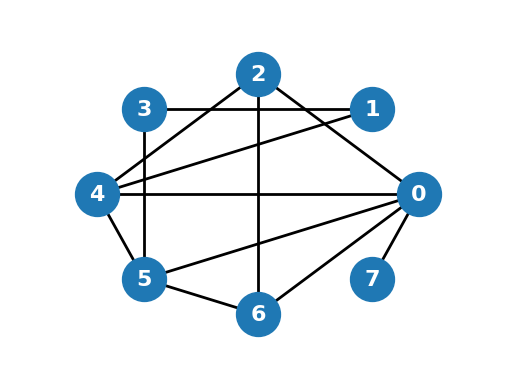

In [17]:
V = [0,1,2,3,4,5,6,7]

k = 3
n = len(V)
V.sort()
print(V)

E = E0[17]

target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

# print the graph
pos = nx.circular_layout(target_graph)
options = {
    "with_labels": True,
    "font_size": 16,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(target_graph, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

info = get_info_neighbors(target_graph)

In [18]:
# Construct the target Hamiltonian
ham = build_ham(target_graph)

# Parameter initialization
counts = 1  # Number of repeated random initializations (RI) for 1-layer ansatz
delta = 0.1  # Convergence threshold for expectation value changes
iterations = []  # Store the number of iterations per optimization round
mixers = []  # Store allowed mixer vertices per layer
values = []  # Store the evolution of expectation values
running_time = []  # Store the runtime of each execution
depth = []  # Store the circuit depth of each execution

times = 5
# times = int(input('Please input the number of the Adaptive QAOA runs:'))  # Number of repeated adaptive ansatz runs

# Generate random seeds for repeated runs
total_SEED = []
for i in range(times):
    total_SEED.append(random.randint(1, 25000))
my_logger.info('Generated random seeds: total_SEED = {}'.format(total_SEED))

# Start adaptive ansatz execution
for i in range(len(total_SEED)):
    start_time = time.time()  # Record start time
    
    # Current seed for this run
    SEED = total_SEED[i]
    
    # Execute adaptive ansatz and retrieve optimization results
    function_values, mixer_nodes, ITR, circuit_depth_layer = adaptive_ansatz(SEED)
    
    # Store results
    iterations.append(ITR)  # Append iteration counts per round
    mixers.append(mixer_nodes)  # Append allowed mixer vertices per layer
    values.append(function_values)  # Append expectation values per layer
    depth.append(circuit_depth_layer)  # Append circuit depth per layer

    # Record runtime
    end_time = time.time()
    delta0 = end_time - start_time
    running_time.append(delta0)

    # Log results
    my_logger.info('Execution {} completed.'.format(i + 1))
    my_logger.info('Expectation values: {}'.format(function_values))
    my_logger.info('Mixer vertices per layer: {}'.format(mixer_nodes))
    my_logger.info('Iteration counts: {}'.format(ITR))
    my_logger.info('Circuit depth per layer: {}'.format(circuit_depth_layer))
    my_logger.info('Runtime: {:.2f}s'.format(delta0))

# Final summary of results
my_logger.info('All expectation values from executions: {}'.format(values))
my_logger.info('All mixer vertices per layer: {}'.format(mixers))
my_logger.info('All iteration counts: {}'.format(iterations))
my_logger.info('All circuit depths: {}'.format(depth))
my_logger.info('All runtimes: {}'.format(running_time))


Generated random seeds: total_SEED = [4298, 23462, 8116, 10457, 15714]
Vertices selected for mixer application in the first layer: [7, 2, 3, 5, 0]



The 1-th global random initialization
SEED = 1705, initial_beta = [0.37379628], initial_gamma = [0.94739044]
This is the function named execute_function, params = [gamma1, beta1, beta2, ...] = [0.94739044, 0.37379628]
weight = [0.94739044 0.37379628]
lr = 0.05, ITR = 600
train_step = 50, loss = -2.917609930038452
Convergence reached after 68 iterations. Expectation value evolution: loss0 = [-0.16802262, -0.2136727, -0.2639711, -0.31863174, -0.37735957, -0.43984872, -0.5057832, -0.57483816, -0.6466805, -0.7209717, -0.7973702, -0.875533, -0.95511866, -1.0357893, -1.1172118, -1.1990606, -1.2810171, -1.3627727, -1.444028, -1.5244955, -1.6038994, -1.6819776, -1.7584838, -1.833189, -1.905883, -1.9763774, -2.044507, -2.1101313, -2.173136, -2.2334325, -2.2909596, -2.34568, -2.397582, -2.4466746, -2.4929864, -2.5365636, -2.5774658, -2.6157637, -2.

In [19]:
my_logger.info('depth = {}'.format(depth))

# Record the circuit depth in each run of the AMA algorithm
max_depth = []
for i in range(0,len(depth)):
    max_depth.append(max(depth[i]))
my_logger.info('max_depth = {}'.format(max_depth))

depth = [[16, 20, 24], [16, 20, 24, 28], [16, 20, 24, 28], [16, 20, 24], [16, 20, 24, 28]]
max_depth = [24, 28, 28, 24, 28]


In [20]:
my_logger.info('values = {}'.format(values))
my_logger.info('\n')
my_logger.info('mixers = {}'.format(mixers))
my_logger.info('\n')
my_logger.info('iterations = {}'.format(iterations))
my_logger.info('\n')

my_logger.info('running_time = {}'.format(running_time))
my_logger.info('\n')

values = [[2.9986, 2.99702, 2.99792], [2.99859, 3.99669, 3.98622, 3.99975], [2.98439, 3.99844, 3.99636, 3.99921], [2.99963, 2.9894, 2.99176], [2.98479, 3.99884, 3.99799, 3.99602]]


mixers = [[[7, 2, 3, 5, 0], [7], [7]], [[3, 7, 4, 5, 1], [6], [6], [6]], [[5, 4, 2, 1, 6], [7], [1], [7]], [[5, 1, 6, 0, 7], [1], [1]], [[5, 2, 7, 4, 6], [1], [7], [7]]]


iterations = [[68.0, 84, 41], [7.0, 51, 20, 47], [26.0, 65, 88, 67], [52.0, 56, 91], [24.0, 33, 63, 69]]


running_time = [55.2762815952301, 77.15391731262207, 107.45925068855286, 71.06150555610657, 93.56131410598755]




In [21]:
# Calculate and store the maximum expectation value from each run
max_loss_run = []  # List to store the maximum expectation value for each run
for i in range(len(values)):
    max_loss_run.append(max(values[i]))  # Append the maximum value from each run's expectation values
my_logger.info('Maximum expectation values for each run: max_loss_run = {}'.format(max_loss_run))

# Calculate and store the total iteration count for each run
total_iter_run = []  # List to store the total iteration count for each run
for i in range(len(iterations)):
    total_iterations = sum(iterations[i])  # Sum all iteration counts for this run
    total_iter_run.append(total_iterations)  # Append the total iterations for this run
my_logger.info('\n')
my_logger.info('Total iteration counts for each run: total_iter_run = {}'.format(total_iter_run))

Maximum expectation values for each run: max_loss_run = [2.9986, 3.99975, 3.99921, 2.99963, 3.99884]


Total iteration counts for each run: total_iter_run = [193.0, 125.0, 246.0, 199.0, 189.0]


In [22]:
# Calculate the degree of allowed mixer vertices for each run
# Used to compute the number of CNOT gates for multi-qubit controlled gates
degrees = []  # Stores degrees of allowed mixer vertices for all runs

# Loop over each run
for i in range(len(mixers)):
    degrees_run = []  # Stores degrees of allowed mixer vertices for each layer in the current run

    # Loop over each layer in the current run
    for j in range(len(mixers[i])):
        degrees_round = []  # Stores degrees of allowed mixer vertices in the current layer

        # Access each allowed mixer vertex in the current layer and store its degree
        for t in range(len(mixers[i][j])):
            node = mixers[i][j][t]  # Allowed mixer vertex
            d = len(info[node])  # Degree of the vertex
            degrees_round.append(d)
        
        degrees_run.append(degrees_round)  # Store degrees for the current layer
    degrees.append(degrees_run)  # Store degrees for the current run
    
# Log the degrees information
my_logger.info('Degrees of allowed mixer vertices: degrees = {}'.format(degrees))

Degrees of allowed mixer vertices: degrees = [[[1, 3, 2, 4, 5], [1], [1]], [[2, 1, 4, 4, 2], [3], [3], [3]], [[4, 4, 3, 2, 3], [1], [2], [1]], [[4, 2, 3, 5, 1], [2], [2]], [[4, 3, 1, 4, 3], [2], [1], [1]]]
